<a href="https://colab.research.google.com/github/therishabhmittal-05/Pytorch/blob/main/Predict_Podcast_Listening_Time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn, optim
import numpy as np
import pandas as pd

In [2]:
dataset = pd.read_csv("/content/drive/MyDrive/PredictPodcastTime/train.csv")

In [3]:
dataset.head(5)

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [4]:
dataset.info()
dataset.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


,0
id,0
Podcast_Name,0
Episode_Title,0
Episode_Length_minutes,87093
Genre,0
Host_Popularity_percentage,0
Publication_Day,0
Publication_Time,0
Guest_Popularity_percentage,146030
Number_of_Ads,1


In [5]:
from sklearn.model_selection import train_test_split
X = dataset.drop(["id","Listening_Time_minutes"], axis=1)
y = dataset["Listening_Time_minutes"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
X_train.shape, y_train.shape

((600000, 10), (600000,))

In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))
])

numeric_cols = X.select_dtypes(include=['number']).columns.tolist()
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

preprocessor = ColumnTransformer([
    ('categorical', categorical_pipeline, categorical_cols),
    ('numeric', numeric_pipeline, numeric_cols)
], remainder='passthrough')

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [8]:
type(X_train), type(X_test), type(y_train), type(y_test)

(numpy.ndarray,
 numpy.ndarray,
 pandas.core.series.Series,
 pandas.core.series.Series)

In [9]:
X_train.shape, y_train.shape

((600000, 176), (600000,))

In [10]:
import seaborn as sb
import matplotlib.pyplot as plt

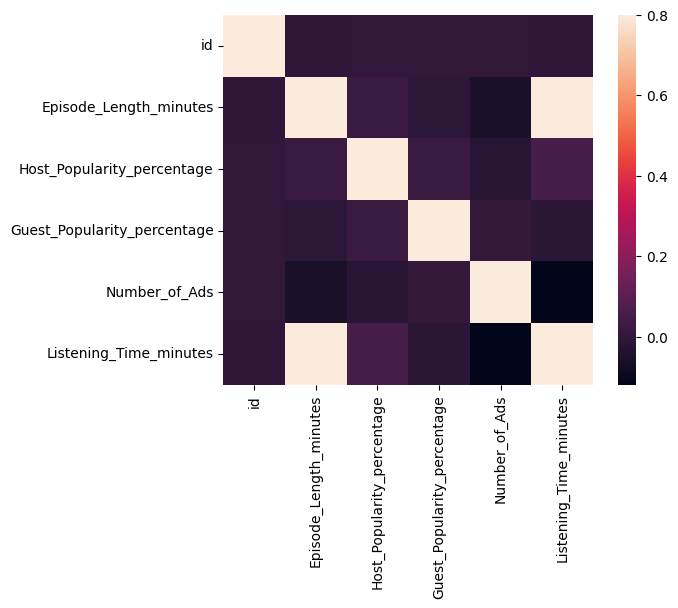

In [11]:
numeric_X = dataset.select_dtypes(include=['number'])
c_mat = numeric_X.corr()
sb.heatmap(c_mat, vmax = .8, square = True)
plt.show()

In [12]:
# dataset.Podcast_Name.nunique()

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [14]:
X_train = torch.from_numpy(X_train).type(torch.float).to(device)
X_test = torch.from_numpy(X_test).type(torch.float).to(device)
y_train = torch.from_numpy(y_train.to_numpy()).type(torch.float).to(device)
y_test = torch.from_numpy(y_test.to_numpy()).type(torch.float).to(device)

In [15]:
type(X_train), type(X_test), type(y_train), type(y_test), X_train.shape, y_train.shape

(torch.Tensor,
 torch.Tensor,
 torch.Tensor,
 torch.Tensor,
 torch.Size([600000, 176]),
 torch.Size([600000]))

In [16]:
class Listening_time_model(nn.Module):
  def __init__(self):
    super().__init__()
    self.regressor = nn.Sequential(
        nn.Linear(in_features=X_train.shape[1], out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=1)
    )

  def forward(self, x):
    return self.regressor(x)

In [17]:
model = Listening_time_model().to(device)
model

Listening_time_model(
  (regressor): Sequential(
    (0): Linear(in_features=176, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [18]:
from torchsummary import summary
summary(model, input_size=(X_train.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]          45,312
              ReLU-2                  [-1, 256]               0
            Linear-3                  [-1, 256]          65,792
              ReLU-4                  [-1, 256]               0
            Linear-5                  [-1, 256]          65,792
              ReLU-6                  [-1, 256]               0
            Linear-7                    [-1, 1]             257
Total params: 177,153
Trainable params: 177,153
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.68
Estimated Total Size (MB): 0.69
----------------------------------------------------------------


In [19]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
y_log = model(X_test)[:5]
y_log

tensor([[0.5796],
        [0.5405],
        [0.6444],
        [0.4792],
        [0.5125]], device='cuda:0', grad_fn=<SliceBackward0>)

In [22]:
epochs = 1000

for epoch in range(epochs):
  model.train()
  y_pred = model(X_train).squeeze()
  loss = torch.sqrt(criterion(y_pred, y_train))
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  with torch.inference_mode():
    test_pred = model(X_test).squeeze()
    test_loss = torch.sqrt(criterion(test_pred, y_test))
  if epoch%100 == 0:
    print(f"Epoch: {epoch} | Train loss: {loss} | Test Loss: {test_loss}")

Epoch: 100 | Train loss: 24.050045013427734 | Test Loss: 26.56186294555664
Epoch: 200 | Train loss: 13.446802139282227 | Test Loss: 13.382843971252441
Epoch: 300 | Train loss: 13.276888847351074 | Test Loss: 13.237334251403809
Epoch: 400 | Train loss: 13.24386215209961 | Test Loss: 13.214666366577148
Epoch: 500 | Train loss: 13.22421932220459 | Test Loss: 13.207551002502441
Epoch: 600 | Train loss: 13.204560279846191 | Test Loss: 13.197515487670898
Epoch: 700 | Train loss: 13.189665794372559 | Test Loss: 13.196532249450684
Epoch: 800 | Train loss: 13.170586585998535 | Test Loss: 13.201301574707031
Epoch: 900 | Train loss: 13.149833679199219 | Test Loss: 13.190361976623535
Epoch: 1000 | Train loss: 13.135489463806152 | Test Loss: 13.19448471069336


In [23]:
sub_df = pd.read_csv("/content/drive/MyDrive/PredictPodcastTime/test.csv")
sub_df.head(5)

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,750000,Educational Nuggets,Episode 73,78.96,Education,38.11,Saturday,Evening,53.33,1.0,Neutral
1,750001,Sound Waves,Episode 23,27.87,Music,71.29,Sunday,Morning,NaN,0.0,Neutral
2,750002,Joke Junction,Episode 11,69.10,Comedy,67.89,Friday,Evening,97.51,0.0,Positive
3,750003,Comedy Corner,Episode 73,115.39,Comedy,23.40,Sunday,Morning,51.75,2.0,Positive
4,750004,Life Lessons,Episode 50,72.32,Lifestyle,58.10,Wednesday,Morning,11.30,2.0,Neutral


In [25]:
sub_df.info(), sub_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           250000 non-null  int64  
 1   Podcast_Name                 250000 non-null  object 
 2   Episode_Title                250000 non-null  object 
 3   Episode_Length_minutes       221264 non-null  float64
 4   Genre                        250000 non-null  object 
 5   Host_Popularity_percentage   250000 non-null  float64
 6   Publication_Day              250000 non-null  object 
 7   Publication_Time             250000 non-null  object 
 8   Guest_Popularity_percentage  201168 non-null  float64
 9   Number_of_Ads                250000 non-null  float64
 10  Episode_Sentiment            250000 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 21.0+ MB


(None,
 id                                 0
 Podcast_Name                       0
 Episode_Title                      0
 Episode_Length_minutes         28736
 Genre                              0
 Host_Popularity_percentage         0
 Publication_Day                    0
 Publication_Time                   0
 Guest_Popularity_percentage    48832
 Number_of_Ads                      0
 Episode_Sentiment                  0
 dtype: int64)

In [26]:
sub_test = preprocessor.transform(sub_df)

In [27]:
sub_test = torch.from_numpy(sub_test).type(torch.float).to(device)

In [28]:
sub_test.shape

torch.Size([250000, 176])

In [29]:
model.eval()
with torch.no_grad():
  pred = model(sub_test).squeeze()

In [30]:
submission = pd.DataFrame(
    {
        "id": sub_df["id"],
        "Listening_Time_minutes": pred.cpu().numpy()
    }
)
submission.to_csv("submission.csv", index=False)

In [31]:
submission.head()

,id,Listening_Time_minutes
0,750000,51.993431
1,750001,18.122513
2,750002,47.451843
3,750003,81.101906
4,750004,46.470158
